#Trabajo final Diplomatura de Ciencias de Datos - Grupo 1

##**Problemática**
Predecir si una persona va a dejar de ser cliente del banco en dos meses.

###*¿Por qué 2 meses?*

Porque si sabemos que el cliente se va el mes que viene no llegamos a actuar para retenerlo. 

###*¿Cómo lo hacemos?*

Utilizando información del mes de septiembre de 2013 como nuestro set de datos, probaremos varios modelos predictivos, elegiremos el mejor y de esta forma podremos pronosticar lo más certeramente posible si un cliente del banco se va a desvincular o no de la organización dentro de dos meses.

###*Mes seleccionado para realizar la predicción:*

Seleccionamos el mes de enero de 2014 y devolvemos en formato csv los números de cliente que nuestro modelo predijo que se darán de baja en marzo de 2014.

## Herramientas utilizadas
*   Numpy
*   Pandas
*   Pyarrow
*   Sklearn
*   Seaborn
*   Drive
*   Tpot


## Importamos las librerias necesarias:

In [ ]:
import pandas as pd
import numpy as np
import pyarrow.csv as pv
import pyarrow.parquet as pq
from google.colab import drive
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from tpot import TPOTClassifier
from sklearn.metrics import make_scorer

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Importamos el archivo original
Primero lo convertimos en .parquet porque el csv original es muy pesado. Leemos el archivo paquet.

In [ ]:
#Convertimos el csv original a parquet porque era muy pesado. Esto no se ejecuta más, ya está convertido.

#path = "/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/MESES_hasta_201404.csv"
#table = pv.read_csv(path)
#pq.write_table(table, path.replace('csv', 'parquet'))

In [ ]:
path = "/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/MESES_hasta_201404.parquet"
dataset = pd.read_parquet(path)

In [ ]:
list(dataset.columns)

['numero_de_cliente',
 'foto_mes',
 'marketing_activo_ultimos90dias',
 'cliente_vip',
 'cliente_sucursal',
 'cliente_edad',
 'cliente_antiguedad',
 'mrentabilidad',
 'mrentabilidad_annual',
 'mcomisiones',
 'mactivos_margen',
 'mpasivos_margen',
 'marketing_coss_selling',
 'tpaquete_premium',
 'tpaquete2',
 'tpaquete3',
 'tpaquete4',
 'tpaquete5',
 'tpaquete6',
 'tpaquete7',
 'tpaquete8',
 'tpaquete9',
 'tcuentas',
 'tcuenta_corriente',
 'mcuenta_corriente_Nopaquete',
 'mcuenta_corriente_Paquete',
 'mcuenta_corriente_dolares',
 'tcaja_ahorro',
 'mcaja_ahorro_Paquete',
 'mcaja_ahorro_Nopaquete',
 'mcaja_ahorro_dolares',
 'mdescubierto_preacordado',
 'mcuentas_saldo',
 'ttarjeta_debito',
 'ctarjeta_debito_transacciones',
 'mautoservicio',
 'ttarjeta_visa',
 'ctarjeta_visa_transacciones',
 'mtarjeta_visa_consumo',
 'ttarjeta_master',
 'ctarjeta_master_transacciones',
 'mtarjeta_master_consumo',
 'cprestamos_personales',
 'mprestamos_personales',
 'cprestamos_prendarios',
 'mprestamos_pren

In [ ]:
dataset.head()

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,tpaquete_premium,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,tcuentas,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ttarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ttarjeta_master,...,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_tconsumos,Master_tadelantosefectivo,Master_mpagominimo,Visa_marca_atraso,Visa_cuenta_estado,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo
0,3333,201312,1,0,455,0,0,-50821769.98,0.0,-56507789.49,-1665338.97,6525184.71,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
1,3333,201312,1,0,455,0,0,-22714055.16,0.0,-18918151.60,2381309.88,-5628062.52,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
2,3333,201312,1,0,455,0,0,104820.19,0.0,129372.14,380702.56,-401687.13,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
3,3333,201312,1,0,455,0,0,-3546587.05,0.0,225130.92,-2181505.34,-1042185.24,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
4,3333,201312,1,0,455,0,0,-7585272.96,0.0,-4932873.63,8533479.37,-10800487.35,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.


## Limpieza, preparación y selección de features:


###Eliminamos clientes con su registro mensual repetido (el 3333)

In [ ]:
# filtramos para ver cuales clientes repiten su foto_mes. 
checkDuplicados=dataset.groupby(['numero_de_cliente','foto_mes'])
checkDuplicados.filter(lambda x: len(x) > 1)  #  es como hacer HAVING COUNT(*) > 1

#Solo el cliente 3333 se comporta asi que lo vamos a sacar porque no nos es relevante tenerlo (es uno solo, si decidimos agruparlo en una fila por mes es demasiado cálculo innecesario, no justifica)

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,tpaquete_premium,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,tcuentas,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ttarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ttarjeta_master,...,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_tconsumos,Master_tadelantosefectivo,Master_mpagominimo,Visa_marca_atraso,Visa_cuenta_estado,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo
0,3333,201312,1,0,455,0,0,-50821769.98,0.000000e+00,-56507789.49,-1665338.97,6525184.71,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
1,3333,201312,1,0,455,0,0,-22714055.16,0.000000e+00,-18918151.60,2381309.88,-5628062.52,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
2,3333,201312,1,0,455,0,0,104820.19,0.000000e+00,129372.14,380702.56,-401687.13,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
3,3333,201312,1,0,455,0,0,-3546587.05,0.000000e+00,225130.92,-2181505.34,-1042185.24,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
4,3333,201312,1,0,455,0,0,-7585272.96,0.000000e+00,-4932873.63,8533479.37,-10800487.35,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
5,3333,201403,.,0,455,0,0,16109631.53,-1.253631e+08,2362829.57,-2333351.97,14082755.35,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
6,3333,201403,.,0,455,0,0,1450087.77,-4.760275e+06,966073.49,-268864.73,682552.15,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
7,3333,201404,0,0,455,0,0,-1351755.68,-1.069960e+07,276455.04,-885610.15,-506022.95,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
8,3333,201404,0,0,455,0,0,2451895.62,-1.524554e+08,-569108.17,8590493.45,-6008438.92,0,S,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,N,0,0.0,N,0,0.0,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.


In [ ]:
check = dataset.loc[(dataset.foto_mes == 201312) & (dataset.numero_de_cliente != 3333)]
check

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,tpaquete_premium,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,tcuentas,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ttarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ttarjeta_master,...,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_tconsumos,Master_tadelantosefectivo,Master_mpagominimo,Visa_marca_atraso,Visa_cuenta_estado,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo
20,5609788,201312,1,0,224,61,235,10.83,10594.09,393.40,-366.89,39.91,8,S,N,N,N,N,N,N,N,N,S,S,0.0,-33.20,0.0,S,3071.60,0.0,0.00,1.17,11264.87,S,0,0.00,S,27,8508.69,S,...,,2760.76,2760.76,0,58.5,0,77502.48,0,0,20131212,2760.76,-9027.64,839.32,20010227,58.5,S,N,1368.9,0,10,71894.37,20140331,,8144.06,6178.14,3350.4,3647.58,512.67,79884.32,0,0,20131226,0,-5266.8,168,19970317,3647.58,S,N,4176.9
36,5609981,201312,1,0,227,64,194,294.72,4974.45,213.19,18.03,51.65,9,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,3258.64,0.0,0.00,1.17,2911.74,S,0,0.00,S,3,1107.99,S,...,,0,0,0,.,.,10530,.,.,20131226,0,.,.,20010309,.,S,S,0,0,10,15795,20140331,,5299.24,6200.11,0,1107.99,0,17550,0,0,20131226,0,-468,0,20010308,1107.99,S,N,573.3
52,5610023,201312,1,0,536,41,89,333.70,5133.72,113.68,159.56,28.49,9,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,2705.85,0.0,0.00,1.17,4215.41,S,2,386.10,S,9,1265.10,S,...,,2980.94,2980.94,0,0,0,79884.32,0,0,20131226,0,-2986.31,0,20060802,0,N,N,1602.9,0,10,71894.37,20150831,,1067.03,1248.42,0,576.16,0,79884.32,0,0,20131226,0,-1093.96,0,20060802,576.16,S,N,58.5
68,5610089,201312,1,0,545,51,235,745.99,9986.96,529.10,76.73,108.64,11,S,N,N,N,N,N,N,N,N,S,S,0.0,-2161.97,0.0,S,2723.21,0.0,0.00,1.17,0.00,S,0,0.00,S,7,4106.84,S,...,,6002.86,6002.86,0,5895.85,0,51224.03,0,0,20131205,6002.86,-7638.87,0,20100112,5895.85,S,N,339.3,0,10,71894.37,20180131,,3522.25,4121.03,0,437.58,0,79884.32,0,0,20131226,0,-9131.41,12.84,20100120,437.58,S,N,971.1
84,5610101,201312,1,0,1217,49,43,4216.01,53982.67,599.34,-0.92,3092.09,10,S,N,N,N,N,N,N,N,N,S,S,0.0,21090.59,0.0,S,69986.95,0.0,94.94,1.17,125110.11,S,17,9686.52,S,9,3326.87,S,...,,5076.55,5076.55,0,58.38,0,104134.38,0,0,20131226,0,-5076.55,0,20130626,58.38,S,N,2574,0,10,117145.5,20210831,,2871.09,3359.17,0,1956.98,0,130167.97,0,0,20131226,0,-2919.48,0,20100809,1956.98,S,N,327.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693912,48198106,201312,0,0,32,30,1,-4.91,-4.91,-4.91,0.00,0.00,6,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,0.00,0.0,0.00,1.17,0.00,S,0,0.00,S,0,0.00,S,...,,0,0,0,.,.,17550,.,.,20131226,0,.,.,20131226,.,S,S,0,0,10,18954,20161231,,0,0,0,.,.,21060,.,.,20131226,0,.,.,20131226,.,S,S,0
2693921,48199742,201312,1,0,365,64,1,462.75,462.75,457.32,4.35,0.29,7,S,N,N,N,N,N,N,N,N,S,S,0.0,-

In [ ]:
datasetSinDuplicados = dataset.loc[dataset.numero_de_cliente != 3333]
datasetSinDuplicados

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,tpaquete_premium,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,tcuentas,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ttarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ttarjeta_master,...,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_tconsumos,Master_tadelantosefectivo,Master_mpagominimo,Visa_marca_atraso,Visa_cuenta_estado,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo
9,5609788,201301,1,0,224,60,224,655.14,4073.79,628.40,-1.66,24.51,9,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,1516.49,0.0,0.00,1.17,691.78,S,1,452.18,S,9,2793.84,S,...,,0,0,0,.,.,61088.74,.,.,20130117,0,.,.,20010227,.,S,S,0,0,10,55276.36,20140331,,2425.8,2838.18,0,154.75,0,61419.47,0,0,20130130,20401.75,-20425.28,3459.58,19970317,154.75,S,N,1368.9
10,5609788,201302,1,0,224,60,225,559.96,4375.05,408.01,109.86,20.01,8,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,2027.32,0.0,0.00,1.17,925.22,S,4,747.79,S,26,10719.30,S,...,,0,0,0,.,.,61755.16,.,.,20130214,0,.,.,20010227,.,S,S,0,0,10,56031.62,20140331,,10234.33,4326.18,7647.98,7742.05,1503.98,62258.68,0,0,20130228,0,-2838.18,0,19970317,7742.05,S,N,3053.7
11,5609788,201303,1,0,224,60,226,692.82,4806.57,463.75,146.03,49.76,8,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,2172.76,0.0,0.00,1.17,2387.26,S,7,1032.74,S,41,19303.46,S,...,,0,0,0,.,.,62754.79,.,.,20130314,0,.,.,20010227,.,S,S,0,0,10,56892.4,20140331,,37106.22,15083.86,28330.41,16326.26,1932.18,63215.12,18087.17,3531.06,20130327,0,-12091.66,1516.01,19970317,16326.26,S,S,26418.6
12,5609788,201304,1,0,224,61,227,1178.52,5675.21,819.85,244.83,61.73,8,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,2255.57,0.0,0.00,1.17,2387.26,S,1,210.64,S,36,19840.01,S,...,,0,0,0,.,.,63668.04,.,.,20130418,0,.,.,20010227,.,S,S,0,0,10,57677.65,20140331,,31944.16,12297.19,25077.47,15436.06,2439.37,64087.63,12224.53,2354.04,20130502,0,-43860.62,5530.8,19970317,15436.06,S,S,20556.9
13,5609788,201305,1,0,224,61,228,1512.28,6908.34,475.00,723.85,162.71,8,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,14443.53,0.0,0.00,1.17,1140.82,S,0,0.00,S,67,18940.14,S,...,,15115.59,2484.65,12630.93,0,0,64581.28,12300.32,2350.53,20130516,15221.7,0,0,20010227,0,N,S,15221.7,0,10,57677.65,20140331,,31944.16,12297.19,25077.47,15436.06,2439.37,64087.63,12224.53,2354.04,20130502,37601.63,-43860.62,5530.8,19970317,15436.06,S,S,20556.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694625,48914938,201404,0,0,161,41,1,0.00,0.00,0.00,0.00,0.00,1,S,N,N,N,N,N,N,N,N,N,N,0.0,0.00,0.0,N,0.00,0.0,0.00,0.00,0.00,N,0,0.00,N,0,0.00,N,...,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.,.,.,.,.,,.,.,.,.,.,.,.,.,.,.,.,.,.,.,S,S,.
2694626,48915521,201404,0,0,1457,59,1,33.71,33.71,33.66,0.05,0.00,6,S,N,N,N,N,N,N,N,N,S,S,0.0,-2.

In [ ]:
#Para ver todas las columnas nos fuimos moviendo de a 30 con iloc
datasetSinDuplicados.iloc[0:10,100:]

,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,tcallcenter,ccallcenter_transacciones,thomebanking,chomebanking_transacciones,tautoservicio,cautoservicio_transacciones,tcajas,tcajas_consultas,tcajas_depositos,tcajas_extracciones,tcajas_otras,ccajeros_propio_transacciones,mcajeros_propio,ccajeros_ajenos_transacciones,mcajeros_ajenos,tmovimientos_ultimos90dias,Master_marca_atraso,Master_cuenta_estado,Master_mfinanciacion_limite,Master_Fvencimiento,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_tconsumos,Master_tadelantosefectivo,Master_mpagominimo,Visa_marca_atraso,Visa_cuenta_estado,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo
9,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,N,0,N,0,N,N,N,N,N,0,0.0,0,0.0,S,0,10,54978.7,20140331,,0,0,0,.,.,61088.74,.,.,20130117,0,.,.,20010227,.,S,S,0,0,10,55276.36,20140331,,2425.8,2838.18,0,154.75,0,61419.47,0,0,20130130,20401.75,-20425.28,3459.58,19970317,154.75,S,N,1368.9
10,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,N,0,N,0,N,N,N,N,N,0,0.0,0,0.0,S,0,10,55578.47,20140331,,0,0,0,.,.,61755.16,.,.,20130214,0,.,.,20010227,.,S,S,0,0,10,56031.62,20140331,,10234.33,4326.18,7647.98,7742.05,1503.98,62258.68,0,0,20130228,0,-2838.18,0,19970317,7742.05,S,N,3053.7
11,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,N,0,N,0,N,N,N,N,N,0,0.0,0,0.0,S,0,10,56478.12,20140331,,0,0,0,.,.,62754.79,.,.,20130314,0,.,.,20010227,.,S,S,0,0,10,56892.4,20140331,,37106.22,15083.86,28330.41,16326.26,1932.18,63215.12,18087.17,3531.06,20130327,0,-12091.66,1516.01,19970317,16326.26,S,S,26418.6
12,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,N,0,N,0,N,N,N,N,N,0,0.0,0,0.0,S,0,10,57300.02,20140331,,0,0,0,.,.,63668.04,.,.,20130418,0,.,.,20010227,.,S,S,0,0,10,57677.65,20140331,,31944.16,12297.19,25077.47,15436.06,2439.37,64087.63,12224.53,2354.04,20130502,0,-43860.62,5530.8,19970317,15436.06,S,S,20556.9
13,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,S,146,N,0,S,N,S,N,N,0,0.0,0,0.0,S,0,10,58121.92,20140331,,15115.59,2484.65,12630.93,0,0,64581.28,12300.32,2350.53,20130516,15221.7,0,0,20010227,0,N,S,15221.7,0,10,57677.65,20140331,,31944.16,12297.19,25077.47,15436.06,2439.37,64087.63,12224.53,2354.04,20130502,37601.63,-43860.62,5530.8,19970317,15436.06,S,S,20556.9
14,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,S,13,N,0,S,N,S,N,N,0,0.0,0,0.0,S,0,10,59165.97,20140331,,116.48,116.48,0,0,0,65741.35,0,0,20130613,116.48,-15221.7,0,20010227,0,N,N,35.1,0,10,59721.31,20140331,,20059.94,9683.52,13786.6,10622.9,1596.76,66358.41,4996.43,929.22,20130627,0,-37639.85,4960.76,19970317,10622.9,S,S,10670.4
15,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,S,25,N,0,S,N,S,N,N,0,0.0,0,0.0,S,0,10,60532.11,20140331,,0,0,0,0,0,67259.32,0,0,20130718,0,-116.48,0,20010227,0,N,N,0,0,10,61209.62,20140331,,4953.95,5796.12,0,2484.99,0,68012.12,0,0,20130801,0,-23813.71,2563.99,19970317,2484.99,S,N,1485.9
16,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,S,35,N,0,S,N,S,N,N,0,0.0,0,0.0,S,0,10,61964.88,20140331,,0,0,0,.,.,68851.32,.,.,20130815,0,.,.,20010227,.,S,S,0,0,10,62875.64,20140331,,22129.09,7113.26,18777.77,14912.93,2456.77,69863.29,4656.22,822.51,20130829,0,-5796.12,0,19970317,14912.93,S,S,10260.9
17,0.0,0,0.0,0,0.0,0,0.0,0,0.0,N,0,S,15,S,1,S,N,S,N,S,0,0.0,0,0.0,S,0,10,63530.95,20140331,,0,0,0,.,.,70591.43,.,.,20130912,0,.,.,20010227,.,S,S,0,0,10,64241.78,20140331,,2084.31,2438.64,0,238.8,0,71381.26,0,0,20130

###Selección de columnas del dataset. 

Con ellas, luego de transformarlas en caso de ser necesario, generaremos los modelos predictivos.


In [ ]:
#seleccionamos las columnas que necesitamos
df=datasetSinDuplicados[['numero_de_cliente','foto_mes','cliente_vip','cliente_edad','cliente_antiguedad','mrentabilidad_annual','mcomisiones','mactivos_margen','mpasivos_margen','tpaquete_premium',
                      'tcuenta_corriente','mcuenta_corriente_Nopaquete','mcuenta_corriente_Paquete','mcuenta_corriente_dolares','tcaja_ahorro','mcaja_ahorro_Paquete','mcaja_ahorro_Nopaquete',
                      'mcaja_ahorro_dolares','mcuentas_saldo','ttarjeta_debito','ctarjeta_debito_transacciones','ctarjeta_visa_transacciones','ctarjeta_master_transacciones','mtarjeta_visa_consumo','mtarjeta_master_consumo','cprestamos_personales','mprestamos_personales',
                      'mcuenta_debitos_automaticos','mttarjeta_master_debitos_automat','mttarjeta_visa_debitos_automatic','cprestamos_prendarios','mprestamos_prendarios','cprestamos_hipotecarios','mprestamos_hipotecarios','tplazo_fijo','mplazo_fijo_dolares','mplazo_fijo_pesos',
                      'tfondos_comunes_inversion','mfondos_comunes_inversion_pesos','mfondos_comunes_inversion_dolare','ttitulos','mtitulos','tseguro_vida_mercado_abierto','tseguro_auto',
                      'tseguro_vivienda','tseguro_accidentes_personales','tcaja_seguridad','mbonos_gobierno','mmonedas_extranjeras','tplan_sueldo','ctarjeta_visa_descuentos','ctarjeta_master_descuentos',
                      'mcomisiones_mantenimiento','mcomisiones_otras','tmovimientos_ultimos90dias','Master_msaldopesos','Master_msaldodolares','Master_mlimitecompra','Master_marca_atraso','Visa_msaldopesos',
                      'Visa_msaldodolares','Visa_mlimitecompra','Visa_marca_atraso','ctransferencias_recibidas','ctransferencias_emitidas','cextraccion_autoservicio']]


###Selección del mes de entrenamiento.
Elegimos septiembre del 2013 para entrenar los modelos predictivos.


In [ ]:
df['foto_mes'].unique()

array([201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308,
       201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404])

In [ ]:
# Filtro los meses entre 201309 y 201311
df2=df[(df.foto_mes >= 201309) & (df.foto_mes <= 201311)]

In [ ]:
df2['foto_mes'].unique()

array([201309, 201310, 201311])

###Creación de la variable target (objetivo)
Utilizamos un lag para ver si el cliente se encuentra en los dos meses posteriores. Si no, se dio de baja.

In [ ]:
# Creo un lag (lo voy a usar para crear la variable objetivo)
df2['Mes_1'] = df2.groupby(['numero_de_cliente'])['foto_mes'].shift(-1)
df2['Mes_2'] = df2.groupby(['numero_de_cliente'])['foto_mes'].shift(-2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Despues de crear el lag puedo descartar foto_mes > 201309
df2=df2[df2.foto_mes == 201309]

In [ ]:
#Verifico el formato de la tabla
df2[['numero_de_cliente', 'foto_mes', 'Mes_1', 'Mes_2']].head(20)

,numero_de_cliente,foto_mes,Mes_1,Mes_2
17,5609788,201309,201310.0,201311.0
33,5609981,201309,201310.0,201311.0
49,5610023,201309,201310.0,201311.0
65,5610089,201309,201310.0,201311.0
81,5610101,201309,201310.0,201311.0
97,5610189,201309,201310.0,201311.0
117,5610521,201309,201310.0,201311.0
133,5610637,201309,201310.0,201311.0
149,5610791,201309,201310.0,201311.0
165,5611258,201309,201310.0,201311.0


In [ ]:
df2['target'] = "Baja+1"
df2.loc[(df2['Mes_1']==201310), 'target'] = "Baja+2"
df2.loc[(df2['Mes_2']==201311), 'target'] = "Continua"
df2['target_bin'] = np.where(df2['target']=='Baja+2', 1, 0)
df2[df2['target']=='Baja+2'] 
df2 = df2.drop(['Mes_1' , 'Mes_2'] , axis='columns')

In [ ]:
df_2013_09.head()

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tpaquete_premium,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_msaldopesos,Master_msaldodolares,Master_mlimitecompra,Master_marca_atraso,Visa_msaldopesos,Visa_msaldodolares,Visa_mlimitecompra,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin
0,17,5609788,201309,0,61,232,9313.23,319.77,110.33,258.27,S,S,0.0,0.00,0.0,S,1350.10,0.0,0.00,1200.74,S,0,8,0,2433.01,0.00,0,0.00,0.00,0.00,177.96,0,0.0,0,0,N,0.00,0.0,N,0.0,0.0,N,0.0,N,N,N,N,N,0,0,N,0,0,273.78,359.41,S,0,0,70591.43,0,2438.64,0,71381.26,0,0,0,0,Continua,0
1,33,5609981,201309,0,64,191,5540.60,56.11,-6.26,55.47,S,S,0.0,0.00,0.0,S,4475.20,0.0,0.00,4389.79,S,0,3,0,1008.55,0.00,0,0.00,11.68,0.00,1008.55,0,0.0,0,0,N,0.00,0.0,N,0.0,0.0,N,0.0,N,N,N,N,N,0,0,N,0,0,24.57,63.07,S,0,0,10530,0,3305.68,0,17550,0,0,0,0,Continua,0
2,49,5610023,201309,0,40,86,4321.00,125.02,96.48,-10.31,S,S,0.0,0.00,0.0,S,2107.31,0.0,0.00,535.67,S,9,5,9,888.31,3150.15,0,0.00,0.00,0.00,539.22,0,0.0,0,0,N,0.00,0.0,N,0.0,0.0,N,0.0,N,N,N,N,S,0,0,S,0,0,64.35,140.52,S,3208.67,0,71381.26,0,631.56,0,71381.26,0,0,0,0,Continua,0
3,65,5610089,201309,0,51,232,9234.52,543.06,-23.37,142.38,S,S,0.0,2313.46,0.0,S,4456.14,0.0,0.00,7893.34,S,0,7,8,4050.49,7972.38,0,0.00,0.00,5390.35,2205.33,0,0.0,0,0,N,0.00,0.0,N,0.0,0.0,N,0.0,N,N,S,N,S,0,0,N,0,0,273.78,610.38,S,8117.07,0,46888.17,0,4062.56,0,71381.26,0,0,0,0,Continua,0
4,81,5610101,201309,0,49,40,55596.73,448.40,339.19,2757.29,S,S,0.0,21437.16,0.0,S,45478.98,0.0,84.35,61856.44,S,11,8,2,3231.77,345.03,1,108357.98,1645.67,58.38,1968.58,0,0.0,0,0,S,777811.13,0.0,N,0.0,0.0,N,0.0,N,N,N,N,N,0,0,S,0,0,307.75,504.00,S,348.5,0,93050.1,0,3257.63,0,116312.62,0,0,5,5,Continua,0


In [ ]:
# Guardo el DF como csv
df2.to_csv("/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09.csv")

###Conversión de variables categoricas a binarias

In [ ]:
#ahora leemos directamente el extracto del dataset
path = "/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09.csv"
df_2013_09 = pd.read_csv(path)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#dropeamos la columna Unnamed:0
df_2013_09 = df_2013_09.drop(['Unnamed: 0'] , axis='columns')

In [ ]:
#df_2014_02['tpaquete_premium'].unique()
#solo hay S -  entonces borramos la columna.
df_2013_09 = df_2013_09.drop(['tpaquete_premium'] , axis='columns')


In [ ]:
df_2013_09['tcuenta_corriente'].unique()
#Hay 'S' y 'N'
tcuenta_corriente = {"tcuenta_corriente": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tcuenta_corriente)
df_2013_09['tcuenta_corriente']

0         1
1         1
2         1
3         1
4         1
         ..
169163    1
169164    1
169165    1
169166    1
169167    1
Name: tcuenta_corriente, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tcaja_ahorro'].unique()
#Hay 'S' y 'N'
tcaja_ahorro = {"tcaja_ahorro": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tcaja_ahorro)
df_2013_09['tcaja_ahorro']

0         1
1         1
2         1
3         1
4         1
         ..
169163    1
169164    1
169165    1
169166    1
169167    1
Name: tcaja_ahorro, Length: 169168, dtype: int64

In [ ]:
df_2013_09['ttarjeta_debito'].unique()
#Hay 'S' y 'N'
ttarjeta_debito = {"ttarjeta_debito": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(ttarjeta_debito)
df_2013_09['ttarjeta_debito']

0         1
1         1
2         1
3         1
4         1
         ..
169163    1
169164    1
169165    1
169166    1
169167    1
Name: ttarjeta_debito, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tplazo_fijo'].unique()
#Hay 'S' y 'N'
tplazo_fijo = {"tplazo_fijo": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tplazo_fijo)
df_2013_09['tplazo_fijo']

0         0
1         0
2         0
3         0
4         1
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: tplazo_fijo, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tfondos_comunes_inversion'].unique()
#Hay 'S' y 'N'
tfondos_comunes_inversion = {"tfondos_comunes_inversion": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tfondos_comunes_inversion)
df_2013_09['tfondos_comunes_inversion']

0         0
1         0
2         0
3         0
4         0
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: tfondos_comunes_inversion, Length: 169168, dtype: int64

In [ ]:
df_2013_09['ttitulos'].unique()
#Hay 'S' y 'N'
ttitulos = {"ttitulos": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(ttitulos)
df_2013_09['ttitulos']

0         0
1         0
2         0
3         0
4         0
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: ttitulos, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tseguro_vida_mercado_abierto'].unique()
#Hay 'S' y 'N'
tseguro_vida_mercado_abierto = {"tseguro_vida_mercado_abierto": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tseguro_vida_mercado_abierto)
df_2013_09['tseguro_vida_mercado_abierto']

0         0
1         0
2         0
3         0
4         0
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: tseguro_vida_mercado_abierto, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tseguro_auto'].unique()
#Hay 'S' y 'N'
tseguro_auto = {"tseguro_auto": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tseguro_auto)
df_2013_09['tseguro_auto']

0         0
1         0
2         0
3         0
4         0
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: tseguro_auto, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tseguro_vivienda'].unique()
#Hay 'S' y 'N'
tseguro_vivienda = {"tseguro_vivienda": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tseguro_vivienda)
df_2013_09['tseguro_vivienda']

0         0
1         0
2         0
3         1
4         0
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: tseguro_vivienda, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tseguro_accidentes_personales'].unique()
#Hay 'S' y 'N'
tseguro_accidentes_personales = {"tseguro_accidentes_personales": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tseguro_accidentes_personales)
df_2013_09['tseguro_accidentes_personales']

0         0
1         0
2         0
3         0
4         0
         ..
169163    0
169164    0
169165    1
169166    1
169167    0
Name: tseguro_accidentes_personales, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tcaja_seguridad'].unique()
#Hay 'S' y 'N'
tcaja_seguridad = {"tcaja_seguridad": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tcaja_seguridad)
df_2013_09['tcaja_seguridad']

0         0
1         0
2         1
3         1
4         0
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: tcaja_seguridad, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tplan_sueldo'].unique()
#Hay 'S' y 'N'
tplan_sueldo = {"tplan_sueldo": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tplan_sueldo)
df_2013_09['tplan_sueldo']

0         0
1         0
2         1
3         0
4         1
         ..
169163    0
169164    0
169165    0
169166    0
169167    0
Name: tplan_sueldo, Length: 169168, dtype: int64

In [ ]:
df_2013_09['tmovimientos_ultimos90dias'].unique()
#Hay 'S' y 'N'
tmovimientos_ultimos90dias = {"tmovimientos_ultimos90dias": {'S':1, 'N':0} }
df_2013_09 = df_2013_09.replace(tmovimientos_ultimos90dias)
df_2013_09['tmovimientos_ultimos90dias']

0         1
1         1
2         1
3         1
4         1
         ..
169163    1
169164    1
169165    1
169166    1
169167    1
Name: tmovimientos_ultimos90dias, Length: 169168, dtype: int64

In [ ]:
df_2013_09['Visa_marca_atraso'].unique() 
# al . le asignaremos -2 para no asumir sin saber
df_2013_09['Visa_marca_atraso'] = df_2013_09['Visa_marca_atraso'].replace('.', -1).astype(int)

In [ ]:
df_2013_09['Master_marca_atraso'].unique() 
# al . le asignaremos -2 para no asumir sin saber
df_2013_09['Master_marca_atraso'] = df_2013_09['Master_marca_atraso'].replace('.', -1).astype(int)

In [ ]:
# Guardo el DF como csv
df_2013_09.to_csv("/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09_bin.csv")

### Sumarización de variables
Decidimos agregar columnas sumando
- la cantidad de prestamos totales
- monto total en prestamos

In [ ]:
#ahora leemos directamente el extracto del dataset
path = "/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09_bin.csv"
df_2013_09 = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#sumamos la cantidad de préstamos por cliente
df_2013_09['cprestamos']=df_2013_09['cprestamos_personales']+df_2013_09['cprestamos_prendarios']+df_2013_09['cprestamos_hipotecarios']

In [ ]:
df_2013_09['mprestamos_personales'].dtypes
df_2013_09['mprestamos_prendarios'].dtypes
df_2013_09['mprestamos_hipotecarios'].unique()
df_2013_09['mprestamos_hipotecarios_2'] = df_2013_09['mprestamos_hipotecarios'].replace('.', 0)
df_2013_09['mprestamos_hipotecarios_2'] = (df_2013_09['mprestamos_hipotecarios_2'].replace('\,','.', regex=True).astype(float))
df_2013_09['mprestamos_hipotecarios'] = df_2013_09['mprestamos_hipotecarios_2'] 
df_2013_09 = df_2013_09.drop(['mprestamos_hipotecarios_2'] , axis='columns')
df_2013_09.head()

,Unnamed: 0,Unnamed: 0.1,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_msaldopesos,Master_msaldodolares,Master_mlimitecompra,Master_marca_atraso,Visa_msaldopesos,Visa_msaldodolares,Visa_mlimitecompra,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin,cprestamos
0,0,17,5609788,201309,0,61,232,9313.23,319.77,110.33,258.27,1,0.0,0.00,0.0,1,1350.10,0.0,0.00,1200.74,1,0,8,0,2433.01,0.00,0,0.00,0.00,0.00,177.96,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,273.78,359.41,1,0,0,70591.43,0,2438.64,0,71381.26,0,0,0,0,Continua,0,0
1,1,33,5609981,201309,0,64,191,5540.60,56.11,-6.26,55.47,1,0.0,0.00,0.0,1,4475.20,0.0,0.00,4389.79,1,0,3,0,1008.55,0.00,0,0.00,11.68,0.00,1008.55,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,24.57,63.07,1,0,0,10530,0,3305.68,0,17550,0,0,0,0,Continua,0,0
2,2,49,5610023,201309,0,40,86,4321.00,125.02,96.48,-10.31,1,0.0,0.00,0.0,1,2107.31,0.0,0.00,535.67,1,9,5,9,888.31,3150.15,0,0.00,0.00,0.00,539.22,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,1,0,0,64.35,140.52,1,3208.67,0,71381.26,0,631.56,0,71381.26,0,0,0,0,Continua,0,0
3,3,65,5610089,201309,0,51,232,9234.52,543.06,-23.37,142.38,1,0.0,2313.46,0.0,1,4456.14,0.0,0.00,7893.34,1,0,7,8,4050.49,7972.38,0,0.00,0.00,5390.35,2205.33,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,1,0,0,0,0,0,273.78,610.38,1,8117.07,0,46888.17,0,4062.56,0,71381.26,0,0,0,0,Continua,0,0
4,4,81,5610101,201309,0,49,40,55596.73,448.40,339.19,2757.29,1,0.0,21437.16,0.0,1,45478.98,0.0,84.35,61856.44,1,11,8,2,3231.77,345.03,1,108357.98,1645.67,58.38,1968.58,0,0.0,0,0.0,1,777811.13,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,307.75,504.00,1,348.5,0,93050.1,0,3257.63,0,116312.62,0,0,5,5,Continua,0,1


In [ ]:
#sumamos el monto de préstamos por cliente
df_2013_09['mprestamos']=df_2013_09['mprestamos_personales']+df_2013_09['mprestamos_prendarios']+df_2013_09['mprestamos_hipotecarios']
df_2013_09.loc[df_2013_09.mprestamos>0]

,Unnamed: 0,Unnamed: 0.1,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_msaldopesos,Master_msaldodolares,Master_mlimitecompra,Master_marca_atraso,Visa_msaldopesos,Visa_msaldodolares,Visa_mlimitecompra,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin,cprestamos,mprestamos
4,4,81,5610101,201309,0,49,40,55596.73,448.40,339.19,2757.29,1,0.0,21437.16,0.0,1,45478.98,0.0,84.35,61856.44,1,11,8,2,3231.77,345.03,1,108357.98,1645.67,58.38,1968.58,0,0.0,0,0.0,1,777811.13,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,307.75,504.00,1,348.5,0,93050.1,0,3257.63,0,116312.62,0,0,5,5,Continua,0,1,108357.98
7,7,133,5610637,201309,0,61,170,8507.52,458.40,313.38,122.72,1,0.0,-191.99,0.0,1,11393.17,0.0,0.00,19614.06,1,3,17,0,4717.94,0.00,2,45414.47,0.00,0.00,686.53,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,1,0,1,1,0,0,0,0,0,0,183.92,515.23,1,0,0,17550,0,4666.54,0,17550,0,0,0,3,Continua,0,2,45414.47
9,9,165,5611258,201309,0,0,232,0.00,316.57,38.87,51.10,1,0.0,1314.89,0.0,1,2899.55,0.0,0.00,3360.91,1,3,6,0,914.16,0.00,1,11899.59,402.16,0.00,586.15,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,0,0,0,273.78,358.59,1,.,.,.,-1,918.06,0,59216.99,0,0,0,0,Continua,0,1,11899.59
12,12,213,5611787,201309,0,74,191,8225.76,238.07,248.88,15.38,1,0.0,-431.68,0.0,1,1084.88,0.0,0.00,1366.15,1,0,9,1,1623.73,442.55,2,42563.89,146.69,0.00,241.31,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,183.92,267.59,1,445.87,0,14040,0,1631.61,0,24570,0,0,0,0,Continua,0,2,42563.89
15,15,261,5612103,201309,0,39,188,4555.86,176.70,164.80,34.88,1,0.0,0.00,0.0,1,1147.26,0.0,0.00,106.59,1,2,28,0,4962.74,0.00,1,27028.47,0.00,0.00,977.53,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,40.95,198.60,1,0,0,14040,0,4977.82,0,21060,0,0,0,0,Continua,0,1,27028.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169157,169157,2691266,47456958,201309,0,40,1,1650.99,76.36,1345.58,0.26,1,0.0,-6.48,0.0,1,26.20,0.0,0.00,0.00,1,0,0,0,0.00,0.00,1,70200.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,1,0,0,0,0,0,0,0,0,85.83,85.83,1,.,.,.,-1,0,0,14040,0,0,0,0,Continua,0,1,70200.00
169160,169160,2691316,47477160,201309,0,0,1,0.00,199.02,1580.17,2.18,1,0.0,0.00,0.0,1,218.98,0.0,0.00,87.52,1,0,0,0,0.00,0.00,1,79560.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0,183.92,225.44,1,.,.,.,-1,0,0,12285,0,0,0,0,Continua,0,1,79560.00
169164,169164,2691347,47485491,201309,0,38,1,1100.59,0.00,921.72,18.96,1,0.0,0.00,0.0,1,1926.59,0.0,0.00,3042.00,1,0,0,0,0.00,0.00,1,46800.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,1,.,.,.,-1,0,0,10530,0

In [ ]:
# Guardo el DF como csv
df_2013_09.to_csv("/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09_clean.csv")

###Uso de la tarjeta de crédito:
Quisimos ver si los gastos estaban subiendo o bajando mes a mes. Para ver esto nos trajimos los consumos de los 2 meses anteriores.

In [ ]:
#ahora leemos directamente el extracto del dataset
path = "/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09_clean.csv"
df_2013_09 = pd.read_csv(path)

In [ ]:
#tomamos los consumos de tarjetas visa y master del mes anterior (201308)
clientes201308 = dataset.loc[dataset.foto_mes==201308]
aux_clientes201308 = clientes201308[['numero_de_cliente','mtarjeta_visa_consumo','mtarjeta_master_consumo']]
df_2013_09 = df_2013_09.merge(aux_clientes201308,on='numero_de_cliente',how="left")
df_2013_09 = df_2013_09.rename(columns = {'mtarjeta_visa_consumo_y': 'mtarjeta_visa_consumo201308', 'mtarjeta_master_consumo_y': 'mtarjeta_master_consumo201308','mtarjeta_visa_consumo_x': 'mtarjeta_visa_consumo', 'mtarjeta_master_consumo_x': 'mtarjeta_master_consumo'}, inplace = False)


In [ ]:
#tomamos los consumos de tarjetas visa y master del mes anterior al anterior (201307)
clientes201307 = dataset.loc[dataset.foto_mes==201307]
aux_clientes201307 = clientes201307[['numero_de_cliente','mtarjeta_visa_consumo','mtarjeta_master_consumo']]
df_2013_09 = df_2013_09.merge(aux_clientes201307,on='numero_de_cliente',how="left")
df_2013_09 = df_2013_09.rename(columns = {'mtarjeta_visa_consumo_y': 'mtarjeta_visa_consumo201307', 'mtarjeta_master_consumo_y': 'mtarjeta_master_consumo201307','mtarjeta_visa_consumo_x': 'mtarjeta_visa_consumo', 'mtarjeta_master_consumo_x': 'mtarjeta_master_consumo'}, inplace = False)


In [ ]:
df_2013_09.head(100)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_msaldopesos,Master_msaldodolares,Master_mlimitecompra,Master_marca_atraso,Visa_msaldopesos,Visa_msaldodolares,Visa_mlimitecompra,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin,cprestamos,mprestamos,mtarjeta_visa_consumo201308,mtarjeta_master_consumo201308,mtarjeta_visa_consumo201307,mtarjeta_master_consumo201307
0,0,0,17,5609788,201309,0,61,232,9313.23,319.77,110.33,258.27,1,0.0,0.00,0.0,1,1350.10,0.0,0.00,1200.74,1,0,8,0,2433.01,0.00,0,0.00,0.00,0.00,177.96,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,273.78,359.41,1,0,0,70591.43,0,2438.64,0,71381.26,0,0,0,0,Continua,0,0,0.00,17259.23,0.00,5816.28,0.00
1,1,1,33,5609981,201309,0,64,191,5540.60,56.11,-6.26,55.47,1,0.0,0.00,0.0,1,4475.20,0.0,0.00,4389.79,1,0,3,0,1008.55,0.00,0,0.00,11.68,0.00,1008.55,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,24.57,63.07,1,0,0,10530,0,3305.68,0,17550,0,0,0,0,Continua,0,0,0.00,1007.05,0.00,944.20,0.00
2,2,2,49,5610023,201309,0,40,86,4321.00,125.02,96.48,-10.31,1,0.0,0.00,0.0,1,2107.31,0.0,0.00,535.67,1,9,5,9,888.31,3150.15,0,0.00,0.00,0.00,539.22,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,1,0,0,64.35,140.52,1,3208.67,0,71381.26,0,631.56,0,71381.26,0,0,0,0,Continua,0,0,0.00,610.40,3150.15,776.14,3206.11
3,3,3,65,5610089,201309,0,51,232,9234.52,543.06,-23.37,142.38,1,0.0,2313.46,0.0,1,4456.14,0.0,0.00,7893.34,1,0,7,8,4050.49,7972.38,0,0.00,0.00,5390.35,2205.33,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,1,0,0,0,0,0,273.78,610.38,1,8117.07,0,46888.17,0,4062.56,0,71381.26,0,0,0,0,Continua,0,0,0.00,3516.07,5299.64,4566.82,5854.32
4,4,4,81,5610101,201309,0,49,40,55596.73,448.40,339.19,2757.29,1,0.0,21437.16,0.0,1,45478.98,0.0,84.35,61856.44,1,11,8,2,3231.77,345.03,1,108357.98,1645.67,58.38,1968.58,0,0.0,0,0.0,1,777811.13,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,307.75,504.00,1,348.5,0,93050.1,0,3257.63,0,116312.62,0,0,5,5,Continua,0,1,108357.98,4183.54,286.65,3143.71,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95,1542,5621018,201309,0,62,285,2982.63,220.03,-41.32,54.15,1,0.0,0.00,0.0,1,2292.28,0.0,5.89,2661.32,1,0,9,1,1347.02,256.67,0,0.00,152.10,0.00,451.37,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,183.92,247.30,1,256.67,0,14040,0,1350.76,0,24570,0,0,0,0,Continua,0,0,0.00,954.95,2260.96,1056.88,4990.12
96,96,96,1558,5621188,201309,0,57,232,7576.41,480.95,5.93,39.54,1,0.0,91.65,0.0,1,317.88,0.0,0.07,443.81,1,12,23,16,4209.57,947.68,0,0.00,0.00,117.29,2795.63,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,

In [ ]:
df_2013_09[['numero_de_cliente','mtarjeta_visa_consumo','mtarjeta_visa_consumo201308','mtarjeta_visa_consumo201307','mtarjeta_master_consumo','mtarjeta_master_consumo201308','mtarjeta_master_consumo201307','target_bin']]

,numero_de_cliente,mtarjeta_visa_consumo,mtarjeta_visa_consumo201308,mtarjeta_visa_consumo201307,mtarjeta_master_consumo,mtarjeta_master_consumo201308,mtarjeta_master_consumo201307,target_bin
0,5609788,2433.01,17259.23,5816.28,0.00,0.00,0.00,0
1,5609981,1008.55,1007.05,944.20,0.00,0.00,0.00,0
2,5610023,888.31,610.40,776.14,3150.15,3150.15,3206.11,0
3,5610089,4050.49,3516.07,4566.82,7972.38,5299.64,5854.32,0
4,5610101,3231.77,4183.54,3143.71,345.03,286.65,0.00,0
...,...,...,...,...,...,...,...,...
169163,47485487,0.00,NaN,NaN,0.00,NaN,NaN,0
169164,47485491,0.00,NaN,NaN,0.00,NaN,NaN,0
169165,47492534,0.00,NaN,NaN,0.00,NaN,NaN,0
169166,47493190,0.00,NaN,NaN,0.00,NaN,NaN,0


In [ ]:
df_2013_09.loc[(df_2013_09.mtarjeta_visa_consumo201307.isna()) | (df_2013_09.mtarjeta_visa_consumo201307.isna())]
# es un 3% de los datos, los volamos porque no podemos entrenar al modelo con clientes que justo este mes se dieron de alta, no tenemos historia de ellos.

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_msaldopesos,Master_msaldodolares,Master_mlimitecompra,Master_marca_atraso,Visa_msaldopesos,Visa_msaldodolares,Visa_mlimitecompra,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin,cprestamos,mprestamos,mtarjeta_visa_consumo201308,mtarjeta_master_consumo201308,mtarjeta_visa_consumo201307,mtarjeta_master_consumo201307
53,53,53,872,5617251,201309,0,45,12,1402.37,126.75,352.30,119.32,1,0.0,0.00,0.0,1,21861.45,0.0,0.0,46.80,1,1,5,8,1633.32,1858.11,1,58500.00,0.00,0.0,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,142.47,1,3059,0,47587.5,0,962.66,0,71060.39,0,0,0,3,Continua,0,1,58500.00,NaN,NaN,NaN,NaN
68,68,68,1110,5618081,201309,0,69,190,4270.00,308.93,15.30,69.98,1,0.0,0.00,0.0,1,517.58,0.0,0.0,493.52,1,0,14,11,3125.09,3205.54,0,0.00,14.62,140.4,281.59,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,183.92,347.24,1,3160.27,0,17550,0,128.82,0,17550,0,0,0,0,Continua,0,0,0.00,NaN,NaN,NaN,NaN
140,140,140,2253,5625757,201309,0,38,168,1799.79,20.65,41.90,16.46,1,0.0,9.88,0.0,1,1535.54,0.0,0.0,443.60,1,5,2,0,574.22,0.00,0,0.00,23.37,0.0,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.00,23.21,1,0,0,12285,0,584.9,0,14040,0,0,0,6,Continua,0,0,0.00,NaN,NaN,NaN,NaN
171,171,171,2749,5628616,201309,0,48,1,0.00,0.00,0.00,0.00,0,0.0,0.00,0.0,0,0.00,0.0,0.0,0.00,0,0,0,0,0.00,0.00,0,0.00,0.00,0.0,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0.00,0.00,0,.,.,.,-1,.,.,.,-1,0,0,0,Baja+1,0,0,0.00,NaN,NaN,NaN,NaN
209,209,209,3339,5632903,201309,0,44,4,33.20,-18.42,0.00,8.78,1,0.0,0.00,0.0,1,896.04,0.0,0.0,110.71,1,0,0,0,0.00,0.00,0,0.00,0.00,0.0,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.00,-20.70,1,0,0,10530,0,0,0,12285,0,0,0,2,Continua,0,0,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169163,169163,169163,2691339,47485487,201309,0,50,1,10.79,10.90,-0.09,0.00,1,0.0,-7.27,0.0,1,0.00,0.0,0.0,0.00,1,0,0,0,0.00,0.00,0,0.00,0.00,0.0,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,12.26,12.26,1,0,0,12285,0,0,0,14040,0,0,0,0,Continua,0,0,0.00,NaN,NaN,NaN,NaN
169164,169164,169164,2691347,47485491,201309,0,38,1,1100.59,0.00,921.72,18.96,1,0.0,0.00,0.0,1,1926.59,0.0,0.0,3042.00,1,0,0,0,0.00,0.00,1,46800.00,0.00,0.0,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,1,.,.,.,-1,0,0,10530,0,0,0,0,Continua,0,1,46800.00,NaN,NaN,NaN,NaN
169165,169165,169165,2691371,47492534,201309,0,59,1,480.91,198.22,241.62,0.00,1,0.0,-43.16,0.0,1,0.21,0.

In [ ]:
df_2013_09 = df_2013_09.loc[(df_2013_09.mtarjeta_visa_consumo201307.notna()) | (df_2013_09.mtarjeta_visa_consumo201307.notna())]

In [ ]:
df_2013_09[['numero_de_cliente','mtarjeta_visa_consumo','mtarjeta_visa_consumo201308','mtarjeta_visa_consumo201307','mtarjeta_master_consumo','mtarjeta_master_consumo201308','mtarjeta_master_consumo201307','target_bin']]

,numero_de_cliente,mtarjeta_visa_consumo,mtarjeta_visa_consumo201308,mtarjeta_visa_consumo201307,mtarjeta_master_consumo,mtarjeta_master_consumo201308,mtarjeta_master_consumo201307,target_bin
0,5609788,2433.01,17259.23,5816.28,0.00,0.00,0.00,0
1,5609981,1008.55,1007.05,944.20,0.00,0.00,0.00,0
2,5610023,888.31,610.40,776.14,3150.15,3150.15,3206.11,0
3,5610089,4050.49,3516.07,4566.82,7972.38,5299.64,5854.32,0
4,5610101,3231.77,4183.54,3143.71,345.03,286.65,0.00,0
...,...,...,...,...,...,...,...,...
168965,46912175,8513.45,3323.72,0.00,3539.79,1875.18,0.00,0
168966,46913533,5413.85,3525.04,0.00,4227.86,2096.52,0.00,0
168967,46914182,2978.58,2978.82,707.85,0.00,0.00,0.00,0
168968,46916366,0.00,0.00,0.00,2314.68,0.00,0.00,0


In [ ]:
df_2013_09.loc[df_2013_09.target_bin == 1]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_msaldopesos,Master_msaldodolares,Master_mlimitecompra,Master_marca_atraso,Visa_msaldopesos,Visa_msaldodolares,Visa_mlimitecompra,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin,cprestamos,mprestamos,mtarjeta_visa_consumo201308,mtarjeta_master_consumo201308,mtarjeta_visa_consumo201307,mtarjeta_master_consumo201307
1543,1543,1543,24616,5788413,201309,0,47,44,13530.57,246.68,641.54,2.24,1,0.0,-3912.42,0.0,1,0.00,0.0,0.00,0.00,1,0,9,8,1356.82,1187.76,4,16062.27,0.00,0.0,88.39,0,0.00,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,1,0,0,1,0,0,0,0,0,0,183.92,277.26,1,18965.02,0,8775,1,14961.5,0,10530,1,0,0,0,Baja+2,1,4,16062.27,3306.80,3917.11,2555.61,6148.57
1738,1738,1738,27721,5808129,201309,0,56,63,7685.20,266.97,199.37,27.47,1,0.0,-2357.32,0.0,1,0.00,0.0,187.02,0.00,1,0,0,0,0.00,0.00,0,0.00,0.00,0.0,923.37,0,0.00,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,273.78,300.06,1,14373.63,0,35528.22,1,21669.9,134.39,35368.51,0,0,0,0,Baja+2,1,0,0.00,2433.26,1290.82,4453.34,1426.54
1854,1854,1854,29526,5820215,201309,0,50,285,2948.08,163.63,4.15,1.56,1,0.0,-205.08,0.0,1,0.00,0.0,0.00,0.00,1,0,0,0,0.00,0.00,0,0.00,0.00,0.0,0.00,0,0.00,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,183.92,183.92,1,0,0,12285,0,-120.31,0,24570,0,0,0,0,Baja+2,1,0,0.00,0.00,0.00,5767.22,0.00
2472,2472,2472,39478,5888998,201309,0,48,192,18903.98,235.93,719.92,28.97,1,0.0,-2116.64,0.0,1,6.01,0.0,51.02,51.12,1,7,21,0,4660.58,0.00,1,2830.37,303.03,0.0,943.02,0,0.00,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,183.92,265.16,1,.,.,.,-1,11974.93,53.8,8775,0,0,0,0,Baja+2,1,1,2830.37,13771.01,0.00,6719.02,4043.73
2483,2483,2483,39648,5890553,201309,0,69,232,5883.09,11.04,-3.19,5.75,0,0.0,0.00,0.0,0,0.00,0.0,0.00,0.00,0,0,0,1,0.00,572.10,0,0.00,0.00,572.1,0.00,0,0.00,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,12.41,1,576.9,0,71060.39,0,.,.,.,-1,0,0,0,Baja+2,1,0,0.00,0.00,572.10,0.00,1883.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167332,167332,167332,2663399,45017352,201309,0,0,14,0.00,325.63,561.69,2.27,1,0.0,-2746.24,0.0,1,0.00,0.0,0.00,0.00,1,0,1,0,58.38,0.00,0,0.00,0.00,0.0,58.38,1,122877.95,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,368.87,1,.,.,.,-1,59.23,0,17550,0,0,0,0,Baja+2,1,1,122877.95,58.38,0.00,58.38,0.00
167745,167745,167745,2669951,45363199,201309,0,39,11,7141.09,226.88,153.71,7.00,1,0.0,-885.44,0.0,1,0.00,0.0,0.00,0.00,1,0,23,0,3009.60,0.00,5,34803.08,0.00,0.0,0.00,0,0.00,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,183.9

In [ ]:
df_2013_09=df_2013_09.drop(['Master_msaldopesos' , 'Master_msaldodolares','Master_mlimitecompra','Visa_msaldopesos','Visa_msaldodolares','Visa_mlimitecompra'], axis='columns')

In [ ]:
df_2013_09=df_2013_09.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'], axis='columns')

In [ ]:
# Guardo el DF como csv
df_2013_09.to_csv("/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09_clean.csv")

##Entrenamiento de los modelos
Teniendo las features transformadas y seleccionadas, entrenamos distintos modelos (KNN, RandomForest y Logistic Regression).

Tomamos un 75% de los datos para entrenamiento y el 25% restante para test.

Entrenamos los tres modelos 3 veces cada uno. 

1.   Con el total de los datos (163964 filas)
2.   Dataset con menos porcentaje de no-baja: con 80000 no-baja y 373 baja (80373 filas)
3.   Dataset balanceado: con 400 no-baja y 373 baja (773 filas) 


###Generación de los 3 datasets y separación train/test.
Separamos los 3 segmentos del dataset en train y test. Solo usaremos el test del total para testear los modelos.

In [ ]:
#ahora leemos directamente el extracto del dataset
path = "/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_2013_09_clean.csv"
df_2013_09 = pd.read_csv(path)

In [ ]:
df_2013_09.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163964 entries, 0 to 163963
Data columns (total 68 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        163964 non-null  int64  
 1   numero_de_cliente                 163964 non-null  int64  
 2   foto_mes                          163964 non-null  int64  
 3   cliente_vip                       163964 non-null  int64  
 4   cliente_edad                      163964 non-null  int64  
 5   cliente_antiguedad                163964 non-null  int64  
 6   mrentabilidad_annual              163964 non-null  float64
 7   mcomisiones                       163964 non-null  float64
 8   mactivos_margen                   163964 non-null  float64
 9   mpasivos_margen                   163964 non-null  float64
 10  tcuenta_corriente                 163964 non-null  int64  
 11  mcuenta_corriente_Nopaquete       163964 non-null  f

In [ ]:
df_2013_09_16300 = df_2013_09
#Acá tenemos todos los datos (163964)

In [ ]:
df_2013_09_yes = df_2013_09.loc[df_2013_09.target_bin == 1]
#Acá tenemos todos los BAJA (373)

In [ ]:
df_2013_09_no = df_2013_09.loc[df_2013_09.target_bin == 0]
#Acá tenemos todos los NO BAJA (163591)

In [ ]:
df_2013_09_80000_no = df_2013_09_no.sample(n = 80000)

In [ ]:
frames80000 = [df_2013_09_80000_no, df_2013_09_yes]
df_2013_09_80000_to_predict = pd.concat(frames80000)
df_2013_09_80000_to_predict.info()
#Concatenamos los 80k no y los yes (TOTAL 80373)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80373 entries, 30329 to 163827
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        80373 non-null  int64  
 1   numero_de_cliente                 80373 non-null  int64  
 2   foto_mes                          80373 non-null  int64  
 3   cliente_vip                       80373 non-null  int64  
 4   cliente_edad                      80373 non-null  int64  
 5   cliente_antiguedad                80373 non-null  int64  
 6   mrentabilidad_annual              80373 non-null  float64
 7   mcomisiones                       80373 non-null  float64
 8   mactivos_margen                   80373 non-null  float64
 9   mpasivos_margen                   80373 non-null  float64
 10  tcuenta_corriente                 80373 non-null  int64  
 11  mcuenta_corriente_Nopaquete       80373 non-null  float64
 12 

In [ ]:
df_2013_09_400_no = df_2013_09_no.sample(n = 400)
framesBALANCEADO = [df_2013_09_400_no, df_2013_09_yes]
#Concatenamos los 400 no y los yes (TOTAL 773)
df_2013_09_balanceado_to_predict = pd.concat(framesBALANCEADO)
df_2013_09_balanceado_to_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 31979 to 163827
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        773 non-null    int64  
 1   numero_de_cliente                 773 non-null    int64  
 2   foto_mes                          773 non-null    int64  
 3   cliente_vip                       773 non-null    int64  
 4   cliente_edad                      773 non-null    int64  
 5   cliente_antiguedad                773 non-null    int64  
 6   mrentabilidad_annual              773 non-null    float64
 7   mcomisiones                       773 non-null    float64
 8   mactivos_margen                   773 non-null    float64
 9   mpasivos_margen                   773 non-null    float64
 10  tcuenta_corriente                 773 non-null    int64  
 11  mcuenta_corriente_Nopaquete       773 non-null    float64
 12  m

In [ ]:
#PREPARAMOS X e y -  TOTAL DE DATOS
Xtotal = df_2013_09_16300.drop(['target' , 'target_bin'] , axis='columns')
ytotal = df_2013_09_16300.target_bin

#Descarto columnas no numericas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
Xtotal = Xtotal.select_dtypes(include=numerics)
Xtotal = Xtotal.fillna(0)

#Separamos en train y test
X_trainTotal, X_testTotal, y_trainTotal, y_testTotal = train_test_split(Xtotal, ytotal,
                                                    test_size=0.25,
                                                    random_state=1234,
                                                    stratify=ytotal)   # Atención: pasamos la "y"

In [ ]:
#PREPARAMOS X e y -  80373 REGISTROS
X80000 = df_2013_09_80000_to_predict.drop(['target' , 'target_bin'] , axis='columns')
y80000 = df_2013_09_80000_to_predict.target_bin

#Descarto columnas no numericas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
X80000 = X80000.select_dtypes(include=numerics)
X80000 = X80000.fillna(0)

#Separamos en train y test
X_train80000, X_test80000, y_train80000, y_test80000 = train_test_split(X80000, y80000,
                                                    test_size=0.25,
                                                    random_state=1234,
                                                    stratify=y80000)   # Atención: pasamos la "y"

In [ ]:
#PREPARAMOS X e y -  773 REGISTROS - BALANCEADO
Xbalanceado = df_2013_09_balanceado_to_predict.drop(['target' , 'target_bin'] , axis='columns')
ybalanceado = df_2013_09_balanceado_to_predict.target_bin

#Descarto columnas no numericas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
Xbalanceado = Xbalanceado.select_dtypes(include=numerics)
Xbalanceado = Xbalanceado.fillna(0)

#Separamos en train y test
X_trainBalanceado, X_testBalanceado, y_trainBalanceado, y_testBalanceado = train_test_split(Xbalanceado, ybalanceado,
                                                    test_size=0.25,
                                                    random_state=1234,
                                                    stratify=ybalanceado)   # Atención: pasamos la "y"

###KNN
Entrenamos un KNeighborsClassifier con los 3 datasets de train y lo testeamos con el test del total.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
#probamos con 3, 5, 10, 15

TOTAL de datos

In [ ]:
#Entreno
clf = knn.fit(X_trainTotal, y_trainTotal)
#Score
clf.score(X_testTotal, y_testTotal)


0.9977312092898442

In [ ]:
# Predict on training set and test set
y_train_total_pred = clf.predict(X_trainTotal)
y_test_total_pred = clf.predict(X_testTotal)

In [ ]:
# Calculo Probabilidades Asociadas
y_test_total_proba = clf.predict_proba(X_testTotal)[:,1]

In [ ]:
# veo la matriz de confusión en train
confusion_matrix(y_trainTotal, y_train_total_pred)

array([[122693,      0],
       [   280,      0]])

In [ ]:
# veo la matriz de confusión en test
confusion_matrix(y_testTotal, y_test_total_pred)

array([[40898,     0],
       [   93,     0]])

In [ ]:
#Ahora puedo obtener Recall y Precision
print('Accuracy')
print('Train:',accuracy_score(y_trainTotal, y_train_total_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainTotal, y_train_total_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainTotal, y_train_total_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9977230774234994
Test: 0.9977312092898442
 
Recall
Train: 0.0
Test: 0.0
 
Precision
Train: 0.0
Test: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


80000 registros

In [ ]:
#Entreno
clf = knn.fit(X_train80000, y_train80000)
#Score
clf.score(X_testTotal, y_testTotal)

0.9977312092898442

In [ ]:
# Predict on training set and test set
y_train_80000_pred = clf.predict(X_train80000)
y_test_total_pred = clf.predict(X_testTotal)

In [ ]:
# Calculo Probabilidades Asociadas
y_test_total_proba = clf.predict_proba(X_testTotal)[:,1]

In [ ]:
# veo la matriz de confusión en train
confusion_matrix(y_train80000, y_train_80000_pred)

array([[59999,     0],
       [  280,     0]])

In [ ]:
# veo la matriz de confusión en test
confusion_matrix(y_testTotal, y_test_total_pred)

array([[40898,     0],
       [   93,     0]])

In [ ]:
#Ahora puedo obtener Recall y Precision
print('Accuracy')
print('Train:',accuracy_score(y_train80000, y_train_80000_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_train80000, y_train_80000_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_train80000, y_train_80000_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9953549328953699
Test: 0.9977312092898442
 
Recall
Train: 0.0
Test: 0.0
 
Precision
Train: 0.0
Test: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Datos balanceados

In [ ]:
#Entreno
clf = knn.fit(X_trainBalanceado, y_trainBalanceado)
#Score
clf.score(X_testTotal, y_testTotal)

0.5708570173940621

In [ ]:
# Predict on training set and test set
y_train_balanceado_pred = clf.predict(X_trainBalanceado)
y_test_total_pred = clf.predict(X_testTotal)

In [ ]:
# Calculo Probabilidades Asociadas
y_test_total_proba = clf.predict_proba(X_testTotal)[:,1]

In [ ]:
# veo la matriz de confusión en train
confusion_matrix(y_trainBalanceado, y_train_balanceado_pred)


array([[217,  83],
       [ 92, 187]])

In [ ]:
# veo la matriz de confusión en test
confusion_matrix(y_testTotal, y_test_total_pred)

array([[23337, 17561],
       [   30,    63]])

In [ ]:
#Ahora puedo obtener Recall y Precision
print('Accuracy')
print('Train:',accuracy_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.697754749568221
Test: 0.5708570173940621
 
Recall
Train: 0.6702508960573477
Test: 0.6774193548387096
 
Precision
Train: 0.6925925925925925
Test: 0.0035746709033136633


###Random Forest
Entrenamos un RandomForestClassifier con los 3 datasets de train y lo testeamos con el test del total.

Total de datos

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
parameters = {'max_features':[10, 15, 20],
             'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_trainTotal, y_trainTotal)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=50), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [10, 15, 20]})

In [ ]:
clf_grid.score(X_trainTotal, y_trainTotal)

0.9977312092898442

In [ ]:
clf_grid.score(X_testTotal, y_testTotal)

0.9977312092898442

In [ ]:
# Predict on training set and test set
y_train_total_pred = clf_grid.predict(X_trainTotal)
y_test_total_pred = clf_grid.predict(X_testTotal)

In [ ]:
print('Accuracy')
print('Train:',accuracy_score(y_trainTotal, y_train_total_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainTotal, y_train_total_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainTotal, y_train_total_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9977312092898442
Test: 0.9977312092898442
 
Recall
Train: 0.0035714285714285713
Test: 0.0
 
Precision
Train: 1.0
Test: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf_grid.best_params_

{'max_depth': 5, 'max_features': 10}

80000 registros

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
parameters = {'max_features':[10, 15, 20],
             'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_train80000, y_train80000)


GridSearchCV(estimator=RandomForestClassifier(n_estimators=50), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [10, 15, 20]})

In [ ]:
clf_grid.score(X_train80000, y_train80000)

0.9953715224207436

In [ ]:
clf_grid.score(X_testTotal, y_testTotal)

0.9977312092898442

In [ ]:
# Predict on training set and test set
y_train_80000_pred = clf_grid.predict(X_train80000)
y_test_total_pred = clf_grid.predict(X_testTotal)

In [ ]:
print('Accuracy')
print('Train:',accuracy_score(y_train80000, y_train_80000_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_train80000, y_train_80000_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_train80000, y_train_80000_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9953715224207436
Test: 0.9977312092898442
 
Recall
Train: 0.0035714285714285713
Test: 0.0
 
Precision
Train: 1.0
Test: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf_grid.best_params_

{'max_depth': 5, 'max_features': 10}

Balanceado

In [ ]:
rf = RandomForestClassifier(n_estimators=50) 
parameters = {'max_features':[10, 15, 20],
             'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_trainBalanceado, y_trainBalanceado)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=50), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [10, 15, 20]})

In [ ]:
clf_grid.score(X_trainBalanceado, y_trainBalanceado)

0.9205526770293609

In [ ]:
clf_grid.score(X_testTotal, y_testTotal)

0.8511136590958991

In [ ]:
# Predict on training set and test set
y_train_balanceado_pred = clf_grid.predict(X_trainBalanceado)
y_test_total_pred = clf_grid.predict(X_testTotal)

In [ ]:
print('Accuracy')
print('Train:',accuracy_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9205526770293609
Test: 0.8511136590958991
 
Recall
Train: 0.8888888888888888
Test: 0.8709677419354839
 
Precision
Train: 0.9429657794676806
Test: 0.013123784834737525


In [ ]:
clf_grid.best_params_

{'max_depth': 5, 'max_features': 20}

###Regresion Logistica
Entrenamos un LogisticRegression con los 3 datasets de train y lo testeamos con el test del total.




In [ ]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter = 10000)

Total datos

In [ ]:
logReg.fit(X_trainTotal, y_trainTotal)

LogisticRegression(max_iter=10000)

In [ ]:
prediction = logReg.predict(X_testTotal)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
logReg.score(X_testTotal, y_testTotal)

0.9976824180917763

In [ ]:
logReg.score(X_trainTotal, y_trainTotal)

0.9977068136908102

In [ ]:
# Predict on training set and test set
y_train_total_pred = logReg.predict(X_trainTotal)
y_test_total_pred = logReg.predict(X_testTotal)

In [ ]:
print('Accuracy')
print('Train:',accuracy_score(y_trainTotal, y_train_total_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainTotal, y_train_total_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainTotal, y_train_total_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9977068136908102
Test: 0.9976824180917763
 
Recall
Train: 0.0
Test: 0.010752688172043012
 
Precision
Train: 0.0
Test: 0.25


80000 registros

In [ ]:
logReg.fit(X_train80000, y_train80000)

LogisticRegression(max_iter=10000)

In [ ]:
prediction = logReg.predict(X_testTotal)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
logReg.score(X_testTotal, y_testTotal)

0.9976092312946745

In [ ]:
logReg.score(X_train80000, y_train80000)

0.9952388062177541

In [ ]:
# Predict on training set and test set
y_train_80000_pred = logReg.predict(X_train80000)
y_test_total_pred = logReg.predict(X_testTotal)

In [ ]:
print('Accuracy')
print('Train:',accuracy_score(y_train80000, y_train_80000_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_train80000, y_train_80000_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_train80000, y_train_80000_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9952388062177541
Test: 0.9976092312946745
 
Recall
Train: 0.0
Test: 0.0
 
Precision
Train: 0.0
Test: 0.0


Balanceado

In [ ]:
logReg.fit(X_trainBalanceado, y_trainBalanceado)

LogisticRegression(max_iter=10000)

In [ ]:
prediction = logReg.predict(X_testTotal)
prediction

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
logReg.score(X_testTotal, y_testTotal)

0.7398941231001928

In [ ]:
logReg.score(X_trainBalanceado, y_trainBalanceado)

0.770293609671848

In [ ]:
# Predict on training set and test set
y_train_balanceado_pred = logReg.predict(X_trainBalanceado)
y_test_total_pred = logReg.predict(X_testTotal)

In [ ]:
print('Accuracy')
print('Train:',accuracy_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.770293609671848
Test: 0.7398941231001928
 
Recall
Train: 0.7741935483870968
Test: 0.7634408602150538
 
Precision
Train: 0.7552447552447552
Test: 0.006628699467836803


###CURVAS ROC
Habiendo pasado por tres entrenamientos con distinto volumen de datos y balanceo en cada modelo (KNN, RandomForest y LogisticRegression), comparamos las curvas ROC y el score (accuracy, recall y precision) de la mejor versión de cada uno, la de los datos balanceados. 
El modelo que mejor aplica para el problema planteado es el RandomForest.


************************How to plot a ROC Curve in Python*************************
roc_auc_score for KNeighborsClassifier:  0.6668308569391358
roc_auc_score for RandomForestClassifier:  0.9230470822507818
roc_auc_score for Logistic Regression:  0.8308303847442129


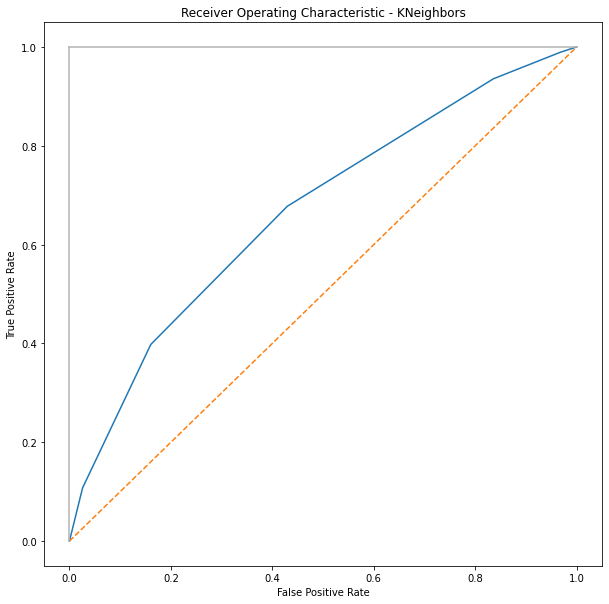

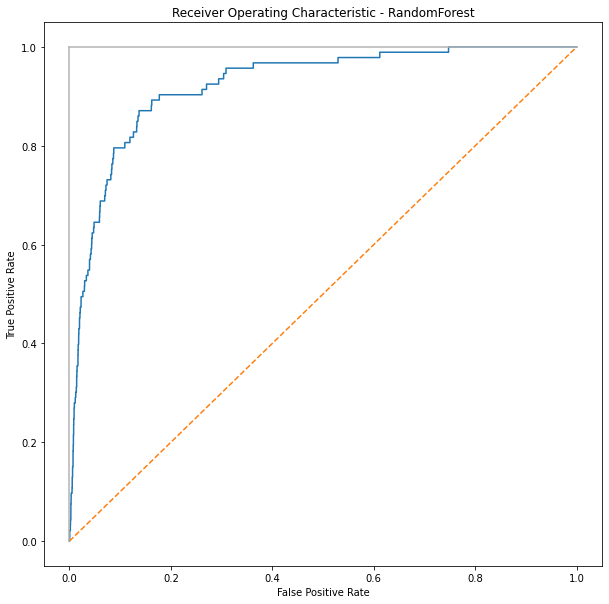

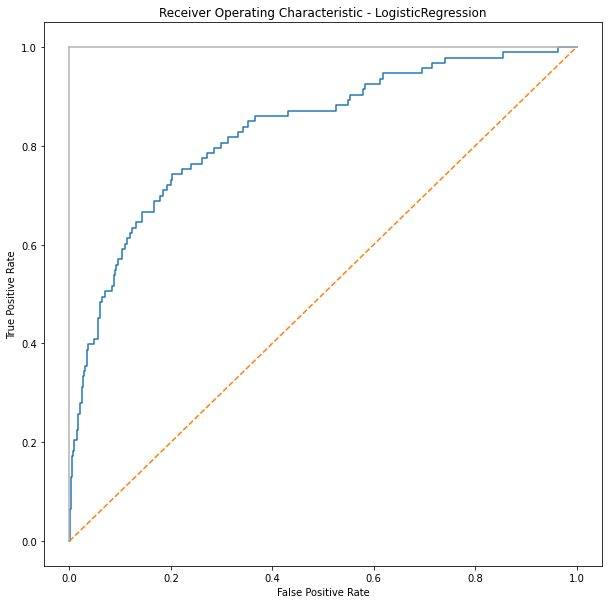

In [ ]:
print()
print(format('How to plot a ROC Curve in Python','*^82'))


import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#clf: KNeighborsClassifier
#clf_grid: RandomForestClassifier
#logReg: Logistic Regression

# Get predicted probabilities
y_score1 = clf.predict_proba(X_testTotal)[:,1]
y_score2 = clf_grid.predict_proba(X_testTotal)[:,1]
y_score3 = logReg.predict_proba(X_testTotal)[:,1]

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testTotal, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_testTotal, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_testTotal, y_score3)
print('roc_auc_score for KNeighborsClassifier: ', roc_auc_score(y_testTotal, y_score1))
print('roc_auc_score for RandomForestClassifier: ', roc_auc_score(y_testTotal, y_score2))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_testTotal, y_score3))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - KNeighbors')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - RandomForest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - LogisticRegression')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Predecimos
Predecimos las bajas del mes de enero de 2014, trayendo el csv con los datos de los clientes de ese mes. Este dataset está transformado al igual que el de entrenamiento, es decir las variables categóricas están binarizadas y está hecha la selección de features.

In [113]:
#ahora leemos directamente el extracto del dataset
path = "/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_predict_final.csv"
clientes_predict = pd.read_csv(path)

In [114]:
clientes_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180541 entries, 0 to 180540
Data columns (total 68 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           180541 non-null  int64  
 1   numero_de_cliente                    180541 non-null  int64  
 2   foto_mes                             180541 non-null  int64  
 3   cliente_vip                          180541 non-null  int64  
 4   cliente_edad                         180541 non-null  int64  
 5   cliente_antiguedad                   180541 non-null  int64  
 6   mrentabilidad_annual                 180541 non-null  float64
 7   mcomisiones                          180541 non-null  float64
 8   mactivos_margen                      180541 non-null  float64
 9   mpasivos_margen                      180541 non-null  float64
 10  tcuenta_corriente                    180541 non-null  int64  
 11  mcuenta_corri

In [116]:
#PREPARAMOS X e y -  TOTAL DE DATOS
Xclientes_predict = clientes_predict.drop(['target' , 'target_bin'] , axis='columns')
yclientes_predict = clientes_predict.target_bin

#Descarto columnas no numericas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
Xclientes_predict = Xclientes_predict.select_dtypes(include=numerics)
Xclientes_predict = Xclientes_predict.fillna(0)

In [117]:
Xclientes_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180541 entries, 0 to 180540
Data columns (total 66 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           180541 non-null  int64  
 1   numero_de_cliente                    180541 non-null  int64  
 2   foto_mes                             180541 non-null  int64  
 3   cliente_vip                          180541 non-null  int64  
 4   cliente_edad                         180541 non-null  int64  
 5   cliente_antiguedad                   180541 non-null  int64  
 6   mrentabilidad_annual                 180541 non-null  float64
 7   mcomisiones                          180541 non-null  float64
 8   mactivos_margen                      180541 non-null  float64
 9   mpasivos_margen                      180541 non-null  float64
 10  tcuenta_corriente                    180541 non-null  int64  
 11  mcuenta_corri

In [118]:
Xclientes_predict = Xclientes_predict.fillna(0)

Predecimos con RandomForest:

In [119]:
clientes_predictRF = Xclientes_predict

In [120]:
prediction_targetRF = clf_grid.predict(clientes_predictRF)

In [121]:
clientes_predictRF['target_bin'] = prediction_targetRF

In [122]:
clientes_predictRF.loc[clientes_predictRF.target_bin == 1]

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_marca_atraso,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,cprestamos,mprestamos,mtarjeta_visa_consumo_mes_ant,mtarjeta_master_consumo_mes_ant,mtarjeta_visa_consumo_mes_ant_ant,mtarjeta_master_consumo_mes_ant_ant,target_bin
0,0,5609788,201401,0,61,236,10324.57,0.0,0.0,0.0,1,0.0,0.00,0.0,1,3954.62,0.0,0.00,1823.93,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,391.57,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,8508.69,2719.73,7795.82,2719.78,1
1,1,5609981,201401,0,64,195,4599.45,0.0,0.0,0.0,1,0.0,0.00,0.0,1,2444.53,0.0,0.00,2056.61,1,0,0,0,0.0,0.0,0,0.00,11.68,0.00,1067.04,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,1107.99,0.00,1067.04,0.00,1
2,2,5610023,201401,0,41,90,5011.20,0.0,0.0,0.0,1,0.0,0.00,0.0,1,2370.60,0.0,0.00,1502.65,1,3,0,0,0.0,0.0,0,0.00,0.00,0.00,604.18,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,1,2,2,0.0,0.0,1,0,0,0,0,0,0,0.00,1265.10,2940.58,1500.92,2940.58,1
3,3,5610089,201401,0,0,236,0.00,0.0,0.0,0.0,1,0.0,-342.55,0.0,1,5196.33,0.0,0.00,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,5996.47,2102.60,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,1,0,1,0,0,0,2,0,0.0,0.0,1,0,0,0,0,0,0,0.00,4106.84,5895.85,9090.56,7502.69,1
5,5,5610189,201401,0,0,129,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,115073.40,0.0,795.52,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,5888.61,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,5888.61,0.00,5825.41,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180536,180536,48411667,201401,0,55,1,0.00,0.0,0.0,0.0,1,0.0,-5.19,0.0,1,0.00,0.0,0.00,-80.58,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,2,5,0.0,0.0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1
180537,180537,48415977,201401,0,43,1,0.00,0.0,0.0,0.0,1,0.0,-5.76,0.0,1,0.00,0.0,0.00,-89.55,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1
180538,180538,48417401,201401,0,39,1,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,0.00,0.0,0.00,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1
180539,180539,48417883,201401,0,0,1,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,6403.09,0.0,0.00,0.00,1,0,0,0,0.0,0.0,2,76255.92,0.00,0.00,0.00,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,2,76255.92,0.00,0.00,0.00,0.00,1


In [123]:
clientes_predictRF.loc[clientes_predictRF.target_bin == 0]

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_marca_atraso,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,cprestamos,mprestamos,mtarjeta_visa_consumo_mes_ant,mtarjeta_master_consumo_mes_ant,mtarjeta_visa_consumo_mes_ant_ant,mtarjeta_master_consumo_mes_ant_ant,target_bin
4,4,5610101,201401,0,49,44,50000.86,0.0,0.0,0.0,1,0.0,21420.51,0.0,1,66531.64,0.0,116.80,72591.43,1,15,0,0,0.0,0.0,2,130376.44,348.07,58.38,417.08,0,0.0,0,0.0,1,817924.51,0.0,0,0.00,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,1,2,2,130376.44,3326.87,4939.03,2892.16,4939.03,0
12,12,5611671,201401,0,44,197,17878.18,0.0,0.0,0.0,1,0.0,595.28,0.0,1,10167.06,0.0,0.00,16266.73,1,0,0,0,0.0,0.0,0,0.00,0.00,199.48,181.18,0,0.0,0,0.0,1,76500.49,0.0,0,0.00,0.0,0,0.0,0,0,0,0,1,0,0,0,2,0,0.0,0.0,1,0,0,0,0,0,0,0.00,2295.80,1372.90,4357.71,353.08,0
14,14,5612030,201401,0,53,106,4000.80,0.0,0.0,0.0,1,0.0,0.00,0.0,1,8668.41,0.0,0.00,18253.82,1,8,0,0,0.0,0.0,0,0.00,2903.41,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.00,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,1,0,0,0,0,3,0,0.00,2342.28,0.00,2854.08,0.00,0
18,18,5612786,201401,0,54,236,3961.19,0.0,0.0,0.0,1,0.0,-76.49,0.0,1,10235.68,0.0,28.13,19365.66,1,4,0,0,0.0,0.0,0,0.00,2114.58,2112.57,234.00,0,0.0,0,0.0,0,0.00,0.0,0,0.00,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,1,0,0,0,0,8,0,0.00,869.98,638.00,551.35,1255.53,0
25,25,5614133,201401,0,36,177,8147.21,0.0,0.0,0.0,1,0.0,0.00,0.0,1,62537.92,0.0,0.00,63461.30,1,25,0,0,0.0,0.0,0,0.00,537.03,0.00,2351.16,0,0.0,0,0.0,0,0.00,0.0,0,0.00,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,1,0,0,0,0,2,0,0.00,3332.16,0.00,2580.62,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179889,179889,47355234,201401,0,62,4,2117.33,0.0,0.0,0.0,1,0.0,0.00,0.0,1,26704.88,0.0,0.00,19337.72,1,16,0,0,0.0,0.0,1,81666.87,0.00,0.00,207.82,0,0.0,0,0.0,0,0.00,0.0,0,0.00,0.0,0,0.0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,1,0,0,0,0,7,1,81666.87,0.00,0.00,0.00,0.00,0
179924,179924,47381507,201401,0,37,5,3406.04,0.0,0.0,0.0,1,0.0,0.00,0.0,1,45481.05,0.0,0.00,54000.29,1,33,0,0,0.0,0.0,0,0.00,0.00,0.00,464.63,0,0.0,0,0.0,0,0.00,0.0,0,0.00,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,1,0,0,0,3,11,0,0.00,2950.79,0.00,0.00,0.00,0
180243,180243,47814440,201401,1,72,3,26350.63,0.0,0.0,0.0,1,0.0,0.00,0.0,1,26999.69,0.0,0.00,26279.14,1,32,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,1,1599412.48,0.0,1,24624.34,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,-1,-1,0,0,15,0,0.00,0.00,0.00,0.00,0.00,0
180244,180244,47816671,201401,0,28,3,3692.81,0.0,0.0,0.0,1,0.0,0.00,0.0,1,29979.55,0.0,0.00,12859.51,1,10,0,0,0.0,0.0,1,113426.23,0.00,0.00,58.38,0,0.0,0,0.0,0,0.00,0.0,0,0.00,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.

In [124]:
#Ahora puedo obtener Recall y Precision
print('Accuracy')
print('Test:',accuracy_score(yclientes_predict, prediction_targetRF))
print(' ')
print('Recall')
print('Test:',recall_score(yclientes_predict, prediction_targetRF))
print(' ')
print('Precision')
print('Test:',precision_score(yclientes_predict, prediction_targetRF))

Accuracy
Test: 0.06530372602345173
 
Recall
Test: 0.9961315280464217
 
Precision
Test: 0.0030425843652519143


LogisticRegression:

In [130]:
Xclientes_predict = Xclientes_predict.drop(['target_bin'] , axis='columns')

In [131]:
clientes_predictLR = Xclientes_predict

In [132]:
prediction_targetLR = logReg.predict(clientes_predictLR)

In [133]:
clientes_predictLR['target_bin'] = prediction_targetLR

In [134]:
clientes_predictLR.loc[clientes_predictLR.target_bin == 1]

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_marca_atraso,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,cprestamos,mprestamos,mtarjeta_visa_consumo_mes_ant,mtarjeta_master_consumo_mes_ant,mtarjeta_visa_consumo_mes_ant_ant,mtarjeta_master_consumo_mes_ant_ant,target_bin
1,1,5609981,201401,0,64,195,4599.45,0.0,0.0,0.0,1,0.0,0.00,0.0,1,2444.53,0.0,0.00,2056.61,1,0,0,0,0.0,0.0,0,0.00,11.68,0.00,1067.04,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,1107.99,0.00,1067.04,0.00,1
2,2,5610023,201401,0,41,90,5011.20,0.0,0.0,0.0,1,0.0,0.00,0.0,1,2370.60,0.0,0.00,1502.65,1,3,0,0,0.0,0.0,0,0.00,0.00,0.00,604.18,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,1,2,2,0.0,0.0,1,0,0,0,0,0,0,0.00,1265.10,2940.58,1500.92,2940.58,1
7,7,5610521,201401,0,72,236,11453.65,0.0,0.0,0.0,1,0.0,-5364.42,0.0,1,0.00,0.0,4.31,-8985.90,1,0,0,0,0.0,0.0,0,0.00,174.09,0.00,1129.37,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,1,0,0,0,0,1,0.0,0.0,1,0,0,0,0,2,0,0.00,5804.07,468.00,5312.53,0.00,1
12,12,5611671,201401,0,44,197,17878.18,0.0,0.0,0.0,1,0.0,595.28,0.0,1,10167.06,0.0,0.00,16266.73,1,0,0,0,0.0,0.0,0,0.00,0.00,199.48,181.18,0,0.0,0,0.0,1,76500.49,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,0,2,0,0.0,0.0,1,0,0,0,0,0,0,0.00,2295.80,1372.90,4357.71,353.08,1
13,13,5611787,201401,0,75,195,7302.76,0.0,0.0,0.0,1,0.0,-700.05,0.0,1,16689.94,0.0,0.00,2992.13,1,0,0,0,0.0,0.0,2,36201.19,149.66,0.00,283.70,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,2,36201.19,1464.10,442.55,1169.00,442.55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180536,180536,48411667,201401,0,55,1,0.00,0.0,0.0,0.0,1,0.0,-5.19,0.0,1,0.00,0.0,0.00,-80.58,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,2,5,0.0,0.0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1
180537,180537,48415977,201401,0,43,1,0.00,0.0,0.0,0.0,1,0.0,-5.76,0.0,1,0.00,0.0,0.00,-89.55,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1
180538,180538,48417401,201401,0,39,1,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,0.00,0.0,0.00,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1
180539,180539,48417883,201401,0,0,1,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,6403.09,0.0,0.00,0.00,1,0,0,0,0.0,0.0,2,76255.92,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,2,76255.92,0.00,0.00,0.00,0.00,1


In [135]:
clientes_predictLR.loc[clientes_predictLR.target_bin == 0]

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_marca_atraso,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,cprestamos,mprestamos,mtarjeta_visa_consumo_mes_ant,mtarjeta_master_consumo_mes_ant,mtarjeta_visa_consumo_mes_ant_ant,mtarjeta_master_consumo_mes_ant_ant,target_bin
0,0,5609788,201401,0,61,236,10324.57,0.0,0.0,0.0,1,0.0,0.00,0.0,1,3954.62,0.0,0.00,1823.93,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,391.57,0,0.00,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,8508.69,2719.73,7795.82,2719.78,0
3,3,5610089,201401,0,0,236,0.00,0.0,0.0,0.0,1,0.0,-342.55,0.0,1,5196.33,0.0,0.00,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,5996.47,2102.60,0,0.00,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,1,0,0,0,2,0,0.0,0.0,1,0,0,0,0,0,0,0.00,4106.84,5895.85,9090.56,7502.69,0
4,4,5610101,201401,0,49,44,50000.86,0.0,0.0,0.0,1,0.0,21420.51,0.0,1,66531.64,0.0,116.80,72591.43,1,15,0,0,0.0,0.0,2,130376.44,348.07,58.38,417.08,0,0.00,0,0.0,1,817924.51,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,1,2,2,130376.44,3326.87,4939.03,2892.16,4939.03,0
5,5,5610189,201401,0,0,129,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,115073.40,0.0,795.52,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,5888.61,0,0.00,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,5888.61,0.00,5825.41,0.00,0
6,6,5610328,201401,0,53,9,5839.32,0.0,0.0,0.0,0,0.0,0.00,0.0,1,0.00,0.0,0.00,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,1,116889.69,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,-1,-1,0,0,0,1,116889.69,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180399,180399,48109715,201401,0,60,2,3262.06,0.0,0.0,0.0,0,0.0,0.00,0.0,1,80.50,0.0,1684534.42,1684579.19,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.00,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,-1,-1,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0
180405,180405,48115060,201401,0,0,2,0.00,0.0,0.0,0.0,1,0.0,13411.41,0.0,1,5.26,0.0,0.00,0.00,1,1,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.00,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0
180416,180416,48128898,201401,0,39,2,147.06,0.0,0.0,0.0,1,0.0,14856.62,0.0,1,0.00,0.0,0.00,17627.51,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,17.55,0,0.00,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,2,0,0.00,0.00,0.00,0.00,0.00,0
180435,180435,48157644,201401,0,0,2,0.00,0.0,0.0,0.0,1,0.0,24632.74,0.0,1,29128.72,0.0,0.00,0.00,1,3,0,0,0.0,0.0,1,115328.74,0.00,0.00,0.00,0,0.00,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,1,115328.74,0.00,0.00,0.00,0.00,0


In [136]:
#Ahora puedo obtener Recall y Precision
print('Accuracy')
print('Test:',accuracy_score(yclientes_predict, prediction_targetLR))
print(' ')
print('Recall')
print('Test:',recall_score(yclientes_predict, prediction_targetLR))
print(' ')
print('Precision')
print('Test:',precision_score(yclientes_predict, prediction_targetLR))

Accuracy
Test: 0.6641372319860863
 
Recall
Test: 0.8123791102514507
 
Precision
Test: 0.006889763779527559


Verificamos cuantos realmente se dieron de baja:

In [137]:
clientes_predict.loc[clientes_predict.target_bin == 1]

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_marca_atraso,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin,cprestamos,mprestamos,mtarjeta_visa_consumo_mes_ant,mtarjeta_master_consumo_mes_ant,mtarjeta_visa_consumo_mes_ant_ant,mtarjeta_master_consumo_mes_ant_ant
242,242,5635987,201401,0,52,173,22901.90,0.0,0.0,0.0,1,0.0,-6023.34,0.0,1,0.00,0.0,0.00,-6270.84,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,1,240356.34,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,-1,-1,0,0,0,Baja+2,1,0,0.00,0.00,0.00,0.00,0.00
1018,1018,5729645,201401,0,35,63,1067.08,0.0,0.0,0.0,0,0.0,0.00,0.0,1,0.00,0.0,8.72,8.72,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,-1,-1,0,0,0,Baja+2,1,0,0.00,0.00,0.00,0.00,0.00
1955,1955,5825356,201401,0,52,187,3268.06,0.0,0.0,0.0,1,0.0,-9.48,0.0,1,109.03,0.0,0.00,-147.23,1,0,0,0,0.0,0.0,0,0.00,11.68,0.00,9.36,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,2,0,0.0,0.0,1,0,0,0,0,0,Baja+2,1,0,0.00,984.04,0.00,1228.94,1376.94
2448,2448,5876688,201401,0,72,236,2517.89,0.0,0.0,0.0,1,0.0,-3965.69,0.0,1,0.00,0.0,7.12,7.12,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,-1,-1,0,0,0,Baja+2,1,0,0.00,0.00,0.00,0.00,0.00
2910,2910,5926415,201401,0,59,61,4468.07,0.0,0.0,0.0,1,0.0,0.00,0.0,1,865.46,0.0,0.00,783.50,1,0,0,0,0.0,0.0,0,0.00,0.00,76.63,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,2,1,0.0,0.0,1,0,0,0,0,0,Baja+2,1,0,0.00,1520.98,1565.93,589.69,820.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179991,179991,47477426,201401,0,53,5,528.46,0.0,0.0,0.0,1,0.0,-47.93,0.0,1,113.84,0.0,0.00,-34.79,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,-1,0,0,0,0,Baja+2,1,0,0.00,411.84,0.00,116.97,0.00
179998,179998,47492534,201401,0,59,5,2552.37,0.0,0.0,0.0,1,0.0,-4667.28,0.0,1,0.00,0.0,0.00,-5066.20,1,0,0,0,0.0,0.0,1,12029.74,0.00,0.00,194.10,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,1,-1,1,0,0,0,Baja+2,1,1,12029.74,5522.42,0.00,9097.35,0.00
180182,180182,47734389,201401,0,63,4,4824.20,0.0,0.0,0.0,1,0.0,-3937.74,0.0,1,0.00,0.0,0.00,-4385.83,1,0,0,0,0.0,0.0,1,80669.18,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1,-1,0,0,0,0,Baja+2,1,1,80669.18,0.00,0.00,0.00,0.00
180367,180367,48063766,201401,0,0,3,0.00,0.0,0.0,0.0,1,0.0,-5.10,0.0,1,178.40,0.0,0.00,0.00,1,0,0,0,0.0,0.0,1,70200.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,-1,0,0,0,0,Baja+2,1,1,70

In [138]:
clientes_predict.loc[clientes_predict.target_bin == 0]

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,ctarjeta_visa_transacciones,ctarjeta_master_transacciones,mtarjeta_visa_consumo,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,mcuenta_debitos_automaticos,mttarjeta_master_debitos_automat,mttarjeta_visa_debitos_automatic,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,tplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,tfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,ttitulos,mtitulos,tseguro_vida_mercado_abierto,tseguro_auto,tseguro_vivienda,tseguro_accidentes_personales,tcaja_seguridad,mbonos_gobierno,mmonedas_extranjeras,tplan_sueldo,ctarjeta_visa_descuentos,ctarjeta_master_descuentos,mcomisiones_mantenimiento,mcomisiones_otras,tmovimientos_ultimos90dias,Master_marca_atraso,Visa_marca_atraso,ctransferencias_recibidas,ctransferencias_emitidas,cextraccion_autoservicio,target,target_bin,cprestamos,mprestamos,mtarjeta_visa_consumo_mes_ant,mtarjeta_master_consumo_mes_ant,mtarjeta_visa_consumo_mes_ant_ant,mtarjeta_master_consumo_mes_ant_ant
0,0,5609788,201401,0,61,236,10324.57,0.0,0.0,0.0,1,0.0,0.00,0.0,1,3954.62,0.0,0.0,1823.93,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,391.57,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,Continua,0,0,0.00,8508.69,2719.73,7795.82,2719.78
1,1,5609981,201401,0,64,195,4599.45,0.0,0.0,0.0,1,0.0,0.00,0.0,1,2444.53,0.0,0.0,2056.61,1,0,0,0,0.0,0.0,0,0.00,11.68,0.00,1067.04,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,Continua,0,0,0.00,1107.99,0.00,1067.04,0.00
2,2,5610023,201401,0,41,90,5011.20,0.0,0.0,0.0,1,0.0,0.00,0.0,1,2370.60,0.0,0.0,1502.65,1,3,0,0,0.0,0.0,0,0.00,0.00,0.00,604.18,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,1,0,0,1,2,2,0.0,0.0,1,0,0,0,0,0,Continua,0,0,0.00,1265.10,2940.58,1500.92,2940.58
3,3,5610089,201401,0,0,236,0.00,0.0,0.0,0.0,1,0.0,-342.55,0.0,1,5196.33,0.0,0.0,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,5996.47,2102.60,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,1,0,1,0,0,0,2,0,0.0,0.0,1,0,0,0,0,0,Continua,0,0,0.00,4106.84,5895.85,9090.56,7502.69
4,4,5610101,201401,0,49,44,50000.86,0.0,0.0,0.0,1,0.0,21420.51,0.0,1,66531.64,0.0,116.8,72591.43,1,15,0,0,0.0,0.0,2,130376.44,348.07,58.38,417.08,0,0.0,0,0.0,1,817924.51,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,1,2,Continua,0,2,130376.44,3326.87,4939.03,2892.16,4939.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180536,180536,48411667,201401,0,55,1,0.00,0.0,0.0,0.0,1,0.0,-5.19,0.0,1,0.00,0.0,0.0,-80.58,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,1,2,5,0.0,0.0,1,0,0,0,0,0,Continua,0,0,0.00,0.00,0.00,0.00,0.00
180537,180537,48415977,201401,0,43,1,0.00,0.0,0.0,0.0,1,0.0,-5.76,0.0,1,0.00,0.0,0.0,-89.55,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,Continua,0,0,0.00,0.00,0.00,0.00,0.00
180538,180538,48417401,201401,0,39,1,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,0.00,0.0,0.0,0.00,1,0,0,0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,Continua,0,0,0.00,0.00,0.00,0.00,0.00
180539,180539,48417883,201401,0,0,1,0.00,0.0,0.0,0.0,1,0.0,0.00,0.0,1,6403.09,0.0,0.0,0.00,1,0,0,0,0.0,0.0,2,76255.92,0.00,0.00,0.00,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,Continua,0,2,76255.

### TPOT
TPOT ofrece el modelo ExtraTreesClassifier que presenta un score similar, pero aún así el RandomForest elegido anteriormente tiene mejor precisión. Al ser similares valida nuestras decisiones. 

In [ ]:
!pip install tpot

     |████████████████████████████████| 87 kB 5.8 MB/s 
     |████████████████████████████████| 173.5 MB 9.3 kB/s 
     |████████████████████████████████| 160 kB 55.6 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=f90910b8bee51f7c38c9c710890564bd2ac312b6eff68a3fa456eafee5fbf9f7
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


Total de datos

In [79]:
# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return float(sum(y_pred == y_true)) / len(y_true)
# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                      scoring=my_custom_scorer,max_time_mins=10)
tpot.fit(X_trainTotal, y_trainTotal)
print(tpot.score(X_testTotal, y_testTotal)) 
#tpot.export('tpot_digits_pipeline.py')

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


14.58 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.001, max_depth=4, min_child_weight=19, n_estimators=100, n_jobs=1, subsample=0.35000000000000003, verbosity=0)
0.9977312092898442


80000 registros

In [81]:
# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return float(sum(y_pred == y_true)) / len(y_true)
# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                      scoring=my_custom_scorer,max_time_mins=10)
tpot.fit(X_train80000, y_train80000)
print(tpot.score(X_testTotal, y_testTotal)) 
#tpot.export('tpot_digits_pipeline.py')

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


14.90 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: SGDClassifier(MaxAbsScaler(input_matrix), alpha=0.01, eta0=1.0, fit_intercept=False, l1_ratio=0.75, learning_rate=invscaling, loss=hinge, penalty=elasticnet, power_t=100.0)
0.9977312092898442


Balanceado

In [82]:
# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return float(sum(y_pred == y_true)) / len(y_true)
# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                      scoring=my_custom_scorer,max_time_mins=10)
tpot.fit(X_trainBalanceado, y_trainBalanceado)
print(tpot.score(X_testTotal, y_testTotal))
#tpot.export('tpot_digits_pipeline.py')

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8341229385307347

Generation 2 - Current best internal CV score: 0.8358320839580211

Generation 3 - Current best internal CV score: 0.8410044977511244

Generation 4 - Current best internal CV score: 0.8410044977511244

Generation 5 - Current best internal CV score: 0.8410344827586206

Best pipeline: ExtraTreesClassifier(StandardScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
0.8469176160620624


In [149]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
etc = ExtraTreesClassifier(bootstrap=False, criterion='gini', max_features=0.4, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
etc.fit(X_trainBalanceado, y_trainBalanceado)

ExtraTreesClassifier(max_features=0.4, min_samples_leaf=4, min_samples_split=16)

In [150]:
prediction = etc.predict(X_testTotal)
prediction

array([0, 0, 0, ..., 0, 1, 0])

In [151]:
etc.score(X_testTotal, y_testTotal)

0.8505769559171525

In [153]:
etc.score(X_trainBalanceado, y_trainBalanceado)

0.918825561312608

In [154]:
# Predict on training set and test set
y_train_balanceado_pred = etc.predict(X_trainBalanceado)
y_test_total_pred = etc.predict(X_testTotal)

In [155]:
print('Accuracy')
print('Train:',accuracy_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainBalanceado, y_train_balanceado_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.918825561312608
Test: 0.8505769559171525
 
Recall
Train: 0.9032258064516129
Test: 0.8602150537634409
 
Precision
Train: 0.9264705882352942
Test: 0.012919896640826873


##Conclusión
A partir de los datos provistos y de las evaluaciones de los diferentes modelos pudimos predecir que el modelo predictivo que se ajusta mejor a la necesidades es el RandomForest que utiliza el dataset balanceado. 
Con el accuracy y recall devolviendo valores aceptables, no tenemos un alto valor de precisión. Pero esto no esta mal, es esperable, ya que el volumen real de datos es gigante en comparación al balanceado. (169000 registros vs 800)

Es posible que la campaña no resulte o no sea 100% eficiente, ya que va a llegar a más clientes de los que realmente se darán de baja, aunque los que se iban a dar de baja van a ser seleccionados casi con certeza. 

Sería necesario para solucionar este problema, contar con un set de datos con más casos de baja reales.

### Clientes que se van a dar de baja: 
Exportamos el csv de clientes del mes de enero de 2014 que se darán de baja.

In [141]:
numeros_de_cliente = clientes_predictLR.loc[clientes_predictLR.target_bin == 1]['numero_de_cliente']

In [142]:
# Guardo el DF como csv
numeros_de_cliente.to_csv("/content/drive/MyDrive/Diplo_Grupo_1/4to bimestre/clientes_que_se_van.csv")

In [143]:
numeros_de_cliente

1          5609981
2          5610023
7          5610521
12         5611671
13         5611787
            ...   
180536    48411667
180537    48415977
180538    48417401
180539    48417883
180540    48418987
Name: numero_de_cliente, Length: 60960, dtype: int64